# Conflict Analysis

**Author:** Florian Klaver

This notebook identifies potential conflict zones where suitable wolf habitat overlaps with livestock grazing areas.

Methodology:  
1. Load Habitat Suitability Index (HSI) from Script 04.
2. Extract livestock grazing areas from Arealstatistik (Sheep vs. Others).
3. Buffer livestock points (200m) to create coherent grazing zones.
4. Filter conflict zones: Only consider grazing areas where HSI > Threshold (0.5).
   -> Logic: Risk = Presence of Prey (Livestock) + Presence of Predator (Good Habitat).

Output:
- conflict_zones_filtered.tif (0=None, 1=Medium Risk, 2=High Risk)

## Setup

In [1]:
import os
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from pathlib import Path

In [2]:
# --- CONFIGURATION ---
try:
    # Try to get the script directory (works for standard .py files)
    script_dir = Path(__file__).parent
except NameError:
    # Fallback for Jupyter Notebooks
    script_dir = Path.cwd()

PROJECT_ROOT = script_dir.parent
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Input Files
PATHS = {
    "habitat": OUTPUT_DIR / "habitat_suitability_final_wlc.tif", 
    "areal": DATA_DIR / "arealstatistik_2056.gpkg",
    "boundaries": DATA_DIR / "swissBOUNDARIES3D_1_5_LV95_LN02.gpkg",
    "water": OUTPUT_DIR / "water_mask_10m.tif"
}

# Output Files
CONFLICT_RASTER_PATH = OUTPUT_DIR / "conflict_zones_filtered.tif"

# --- PARAMETERS ---
PARAMS = {
    "grazing_buffer": 200,     # Buffer radius (meters) around Arealstatistik points
    "habitat_threshold": 0.50, # Minimum Habitat Score required to consider an area a conflict zone.
                               # Removes pastures in urban/unsuitable areas.
    
    # Filter Arealstatistik Codes
    # 49: Sheep Alpages (High Vulnerability -> High Risk)
    "codes_sheep": [49],       
    
    # Other Pastures (Medium Vulnerability / Presence)
    # 43: Home pastures (near settlements) -> Critical if overlapping with Wolf Habitat!
    # 44: Scrub home pastures
    # 45: Alpine meadows (Hay/Aftergrazing)
    # 46: Favorable alpine pastures (Often cattle -> hardier than sheep)
    # 47: Scrub alpine pastures
    # 48: Stony alpine pastures
    "codes_other": [43, 44, 45, 46, 47, 48] 
}

## Process

In [3]:
# --- FUNCTIONS ---

def get_graubuenden_boundary():
    """Loads and dissolves the boundary of Graubünden for spatial filtering."""
    try:
        gdf = gpd.read_file(PATHS["boundaries"], layer='TLM_KANTONSGEBIET')
        
        # Robust filtering for Graubünden
        if 'NAME' in gdf.columns:
            gdf = gdf[gdf['NAME'].isin(['Graubünden', 'Grigioni', 'Grischun'])]
        elif 'kantonsnummer' in gdf.columns:
            gdf = gdf[gdf['kantonsnummer'] == 18]
            
        # Handle Geometry Dissolve (Deprecation fix)
        try:
            return gdf.geometry.union_all()
        except AttributeError:
            return gdf.geometry.unary_union
    except Exception as e:
        print(f"Error loading boundaries: {e}")
        return None

def read_raster(path):
    """Reads a raster file."""
    with rasterio.open(path) as src:
        return src.read(1), src.profile, src.nodata

def create_mask_from_codes(gdf, codes, buffer_dist, shape, transform):
    """
    Filters a GeoDataFrame by Arealstatistik codes, buffers points, 
    and rasterizes the result into a binary mask.
    """
    # Filter by codes
    subset = gdf[gdf['AS18_72'].isin(codes)]
    
    if subset.empty:
        return np.zeros(shape, dtype=rasterio.uint8)
    
    # Buffer points to create zones
    zones = subset.buffer(buffer_dist)
    
    # Rasterize
    mask = features.rasterize(
        ((geom, 1) for geom in zones),
        out_shape=shape, 
        transform=transform, 
        fill=0, 
        default_value=1, 
        dtype=rasterio.uint8
    )
    return mask

In [4]:
# ==========================================
# MAIN EXECUTION
# ==========================================

print("\n" + "="*40)
print("STARTING CONFLICT ANALYSIS")
print("="*40)

# --- 1. LOAD MAPS ---
if not PATHS["habitat"].exists():
    print("CRITICAL ERROR: Habitat Map not found. Please run Script 8 first.")
    exit()

print("1. Loading Habitat Suitability Map...")
habitat, profile, nodata_hab = read_raster(PATHS["habitat"])
water, _, _ = read_raster(PATHS["water"])

# Mask NoData values
habitat_masked = np.ma.masked_where(habitat == nodata_hab, habitat)
water_masked = np.ma.masked_where(water != 1, water)

# --- 2. PREPARE LIVESTOCK MASKS ---
print("2. Processing Livestock Data (Arealstatistik)...")
gr_geom = get_graubuenden_boundary()
gdf_areal = gpd.read_file(PATHS["areal"], layer='arealstatistik_all', mask=gr_geom)

if 'AS18_72' in gdf_areal.columns:
    # Get spatial reference from habitat map
    with rasterio.open(PATHS["habitat"]) as src:
        h_shape = src.shape
        h_transform = src.transform

    print(f"   -> Creating High Risk Mask (Sheep, Codes {PARAMS['codes_sheep']})...")
    mask_sheep = create_mask_from_codes(gdf_areal, PARAMS['codes_sheep'], PARAMS['grazing_buffer'], h_shape, h_transform)
    
    print(f"   -> Creating Medium Risk Mask (Cattle/Other, Codes {PARAMS['codes_other']})...")
    mask_other = create_mask_from_codes(gdf_areal, PARAMS['codes_other'], PARAMS['grazing_buffer'], h_shape, h_transform)
else:
    print("Error: Column 'AS18_72' not found in Arealstatistik.")
    exit()

# --- 3. FILTERING WITH HABITAT SUITABILITY ---
print(f"3. Filtering Conflicts (Habitat Score > {PARAMS['habitat_threshold']})...")

# Logic: Conflict = Livestock Zone AND Suitable Wolf Habitat
# We ignore pastures in unsuitable areas (e.g., middle of a city)

# A. High Priority Conflict (Sheep + Good Habitat)
conflict_sheep = np.where((mask_sheep == 1) & (habitat >= PARAMS['habitat_threshold']), 1, 0)

# B. Medium Priority Conflict (Other Pastures + Good Habitat)
conflict_other = np.where((mask_other == 1) & (habitat >= PARAMS['habitat_threshold']), 1, 0)

# Prioritize Sheep: Remove overlap from Medium (if a pixel is both, it counts as High Risk)
conflict_other = np.where((conflict_other == 1) & (conflict_sheep == 0), 1, 0)

print(f"   -> High Risk Pixels (Sheep): {np.sum(conflict_sheep)}")
print(f"   -> Medium Risk Pixels (Other): {np.sum(conflict_other)}")


STARTING CONFLICT ANALYSIS
1. Loading Habitat Suitability Map...
2. Processing Livestock Data (Arealstatistik)...
   -> Creating High Risk Mask (Sheep, Codes [49])...
   -> Creating Medium Risk Mask (Cattle/Other, Codes [43, 44, 45, 46, 47, 48])...
3. Filtering Conflicts (Habitat Score > 0.5)...
   -> High Risk Pixels (Sheep): 4977044
   -> Medium Risk Pixels (Other): 24820556


4. Exporting Conflict Raster...
✅ Success! Saved to: c:\Workspace\ZHAW\5. Semester\GIS\Wolf_habitat_suitability_Graubunden\output\conflict_zones_filtered.tif
5. Generating Preview Plot...


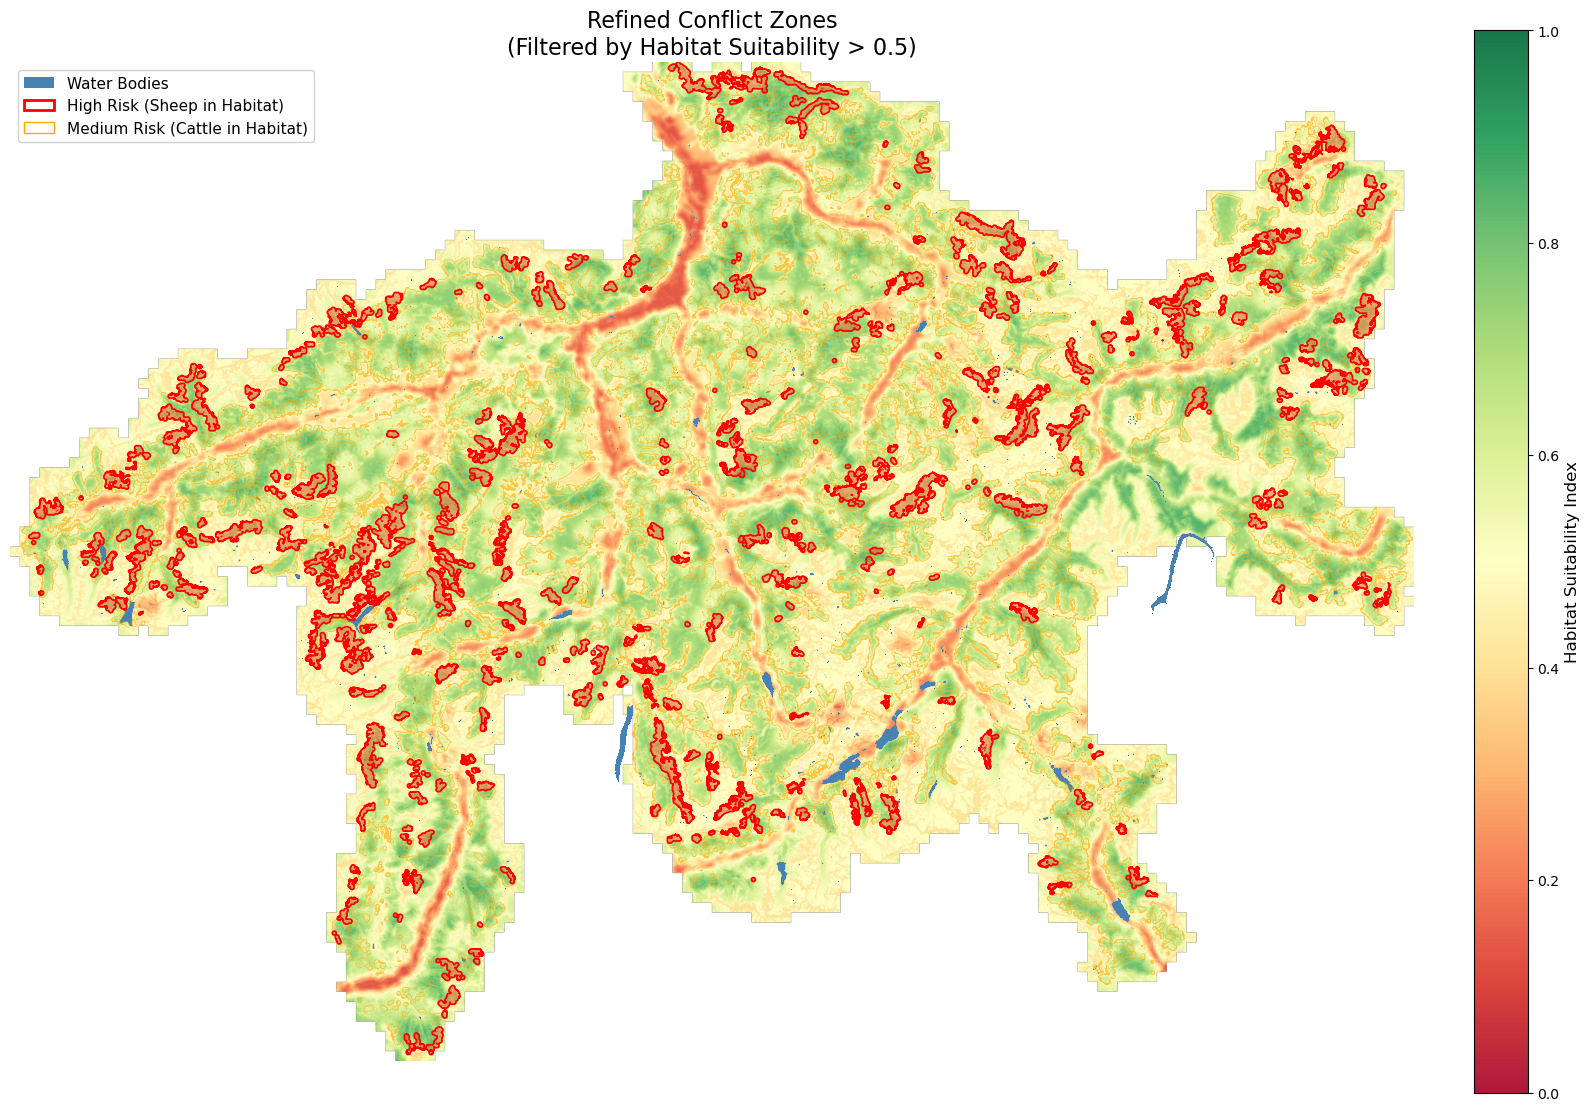

In [5]:
# --- 4. EXPORT ---
print("4. Exporting Conflict Raster...")
# Combine into one raster: 2=High Risk, 1=Medium Risk, 0=None
final_conflict_raster = conflict_other + (conflict_sheep * 2)

profile.update(dtype=rasterio.uint8, count=1, nodata=0)
with rasterio.open(CONFLICT_RASTER_PATH, 'w', **profile) as dst:
    dst.write(final_conflict_raster.astype(rasterio.uint8), 1)
print(f"✅ Success! Saved to: {CONFLICT_RASTER_PATH}")


# --- 5. VISUALIZATION ---
print("5. Generating Preview Plot...")
fig, ax = plt.subplots(figsize=(16, 12))

# Layer 1: Habitat Suitability (Background)
im = ax.imshow(habitat_masked, cmap='RdYlGn', vmin=0, vmax=1, alpha=0.9)

# Layer 2: Water (Blue)
ax.imshow(water_masked, cmap=ListedColormap(['#4682B4']), interpolation='none', alpha=1)

# Layer 3: Conflict Overlays
# A. Medium Conflict (Other Pastures) - Orange Outline
mask_other_plot = np.ma.masked_where(conflict_other != 1, conflict_other)
ax.contour(conflict_other, levels=[0.5], colors='#FFA500', linewidths=0.6, alpha=0.6) 

# B. High Conflict (Sheep) - Red Outline & Fill
mask_sheep_plot = np.ma.masked_where(conflict_sheep != 1, conflict_sheep)
ax.contour(conflict_sheep, levels=[0.5], colors='#FF0000', linewidths=1.2, alpha=1.0) 
ax.imshow(mask_sheep_plot, cmap=ListedColormap(['#FF0000']), alpha=0.3, interpolation='none')

# Styling
cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("Habitat Suitability Index", fontsize=12)

legend_elements = [
    Patch(facecolor='#4682B4', label='Water Bodies'),
    Patch(facecolor='none', edgecolor='#FF0000', linewidth=2, label='High Risk (Sheep in Habitat)'),
    Patch(edgecolor='#FFA500', facecolor='none', linewidth=1, label='Medium Risk (Cattle in Habitat)')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11, frameon=True, facecolor='white', framealpha=0.9)

ax.set_title(f"Refined Conflict Zones\n(Filtered by Habitat Suitability > {PARAMS['habitat_threshold']})", fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()